<a href="https://colab.research.google.com/github/StepDaria/AlfaBattle/blob/main/alfabattle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION

In [ ]:
import pandas as pd
import gc
import tqdm
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
PATH_TO_WORKDIR = '../working/'

PATH_TO_TRAIN_TARGET = '../input/alpha-battle/alfabattle2_sand_alfabattle2_train_target.csv'
PATH_TO_TEST_TARGET = '../input/alpha-battle-test/alfabattle2_sand_alfabattle2_test_target_contest.csv'

PATH_TO_TRAIN = '../input/alpha-battle/alfabattle2_sand_alfabattle2_train_transactions_contest/train_transactions_contest'

PATH_TO_TEST = '../input/alpha-battle/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'

# EDA

## Target

In [ ]:
train_target = pd.read_csv(PATH_TO_TRAIN_TARGET)
train_target.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


0    0.972425
1    0.027575
Name: flag, dtype: float64

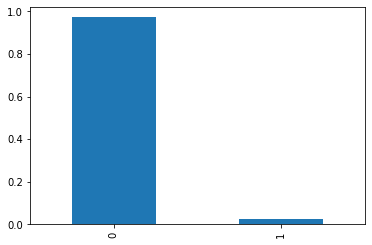

In [ ]:
train_target['flag'].value_counts('mean').plot.bar();
train_target['flag'].value_counts('mean')

Несбалансированность

0    0.521502
1    0.273356
2    0.079357
3    0.066899
4    0.058886
Name: product, dtype: float64

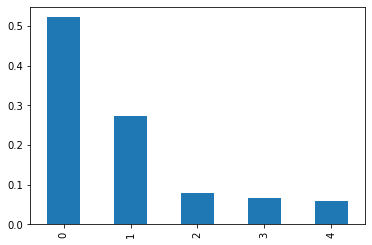

In [ ]:
train_target['product'].value_counts('mean').plot.bar();
train_target['product'].value_counts('mean')

4 вида кредитных продуктов

product
0    0.022836
1    0.025032
2    0.070641
3    0.019821
4    0.032121
Name: flag, dtype: float64

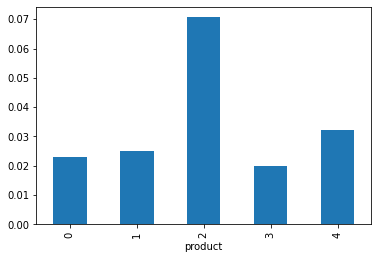

In [ ]:
train_target.groupby(['product'])['flag'].mean().plot.bar();
train_target.groupby(['product'])['flag'].mean()

Неравномерное распределение дефолта по продуктам

product
0    11478
1     6595
2     5403
3     1278
4     1823
Name: flag, dtype: int64

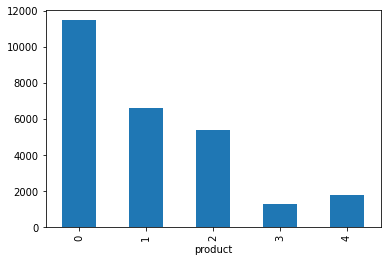

In [ ]:
train_target.groupby(['product'])['flag'].sum().plot.bar();
train_target.groupby(['product'])['flag'].sum()

С учетом большого количества запросов на кредиты типа 1, там валовое количество дефолтов больше

In [ ]:
test_target = pd.read_csv(PATH_TO_TEST_TARGET)
test_target.head()

,app_id,product
0,1063620,0
1,1063621,0
2,1063622,1
3,1063623,1
4,1063624,2


0    0.505138
1    0.287262
4    0.077740
3    0.070531
2    0.059330
Name: product, dtype: float64

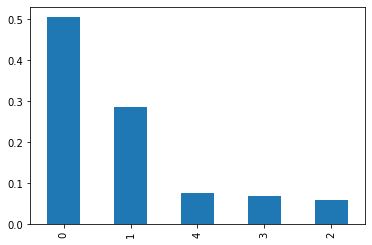

In [ ]:
test_target['product'].value_counts('mean').plot.bar();
test_target['product'].value_counts('mean')

В тестовой выборке похожее распределение заявок по типам кредитов

## Features

Базовая функция для предварительной обработкии пакета parquet файлов

In [ ]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0, 
                                    num_parts_to_read: int = 1, 
                                    verbose=False) -> pd.DataFrame:
    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) 
                                for filename in os.listdir(path_to_dataset) 
                                if filename.startswith('part')])
    
    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset"):
        chunk = pd.read_parquet(chunk_path)
        res.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

In [ ]:
df = read_parquet_dataset_from_local(PATH_TO_TRAIN)
df.head()

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5


In [ ]:
df.describe()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
count,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06,5.408648e+06
mean,1.196700e+04,3.731903e-01,1.102897e+00,1.432612e+00,5.370986e+01,2.666638e+00,1.080972e+00,1.101041e+00,2.107173e+00,1.082360e+00,1.296138e+01,1.563146e+00,2.034708e+01,4.408043e+00,3.860936e+00,1.416821e+01,1.681312e+02,2.594536e+01,3.192437e+01,2.706400e+02
std,6.861200e+03,9.935179e-02,8.109217e-01,9.207239e-01,4.874927e+01,2.811152e+00,2.779329e-01,3.014216e-01,1.263018e+00,2.749573e-01,2.127896e+01,2.829418e+00,3.477612e+01,4.543977e+00,1.997089e+00,4.836613e+00,1.022449e+02,1.474290e+01,9.514843e+01,3.021303e+02
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00
25%,6.064000e+03,3.030730e-01,1.000000e+00,1.000000e+00,1.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.100000e+01,7.900000e+01,1.300000e+01,1.000000e+00,7.100000e+01
50%,1.203000e+04,3.590501e-01,1.000000e+00,1.000000e+00,4.400000e+01,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,2.000000e+00,4.000000e+00,1.500000e+01,1.630000e+02,2.600000e+01,6.000000e+00,1.770000e+02
75%,1.795800e+04,4.318899e-01,1.000000e+00,1.000000e+00,7.500000e+01,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.300000e+01,6.000000e+00,6.000000e+00,1.800000e+01,2.540000e+02,3.800000e+01,2.400000e+01,3.640000e+02
max,2.364600e+04,9.652161e-01,1.100000e+01,7.000000e+00,1.750000e+02,2.200000e+01,3.000000e+00,3.000000e+00,7.000000e+00,3.000000e+00,1.080000e+02,2.400000e+01,1.630000e+02,2.800000e+01,7.000000e+00,2.300000e+01,3.590000e+02,5.300000e+01,8.011000e+03,4.183000e+03


amnt явно пересчитана

In [ ]:
df.nunique()

app_id                   22743
amnt                    422052
currency                    11
operation_kind               7
card_type                  121
operation_type              20
operation_type_group         3
ecommerce_flag               3
payment_system               6
income_flag                  3
mcc                        108
country                     24
city                       161
mcc_category                28
day_of_week                  7
hour                        24
days_before                359
weekofyear                  53
hour_diff                 2435
transaction_number        4183
dtype: int64

In [ ]:
CAT_COLUMNS = ['currency', 'operation_kind', 'card_type',
               'operation_type', 'operation_type_group', 'ecommerce_flag',
               'payment_system', 'income_flag', 'mcc', 'country', 'city',
               'mcc_category', 'day_of_week', 'hour','weekofyear']

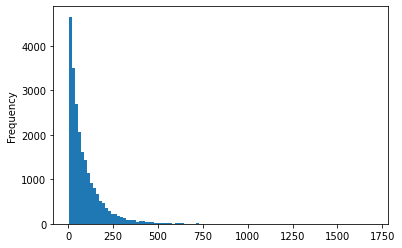

In [ ]:
df.groupby(['app_id'])['amnt'].sum().plot.hist(bins=100);

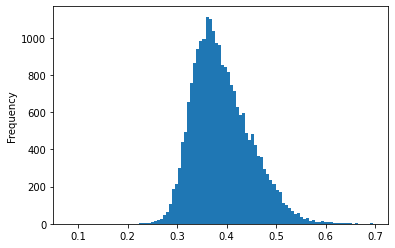

In [ ]:
df.groupby(['app_id'])['amnt'].mean().plot.hist(bins=100);

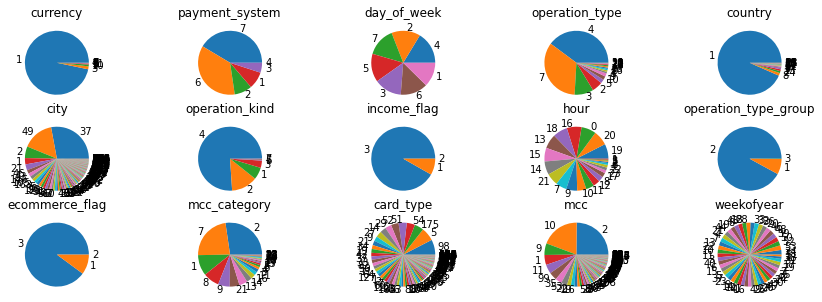

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,5))
for i, col in enumerate(CAT_COLUMNS):
    axes[i % 3][i % 5].pie(df[col].value_counts(), labels=df[col].unique())
    axes[i % 3][i % 5].set_title(col)
plt.show()

In [ ]:
df_min_max_day = df.groupby(['app_id'])['days_before'].agg(['min', 'max'])

In [ ]:
df_min_max_day[df_min_max_day['max'] == df_min_max_day['min']]

,min,max
app_id,,
21355,347,347


In [ ]:
df[df['app_id'] == 21355]

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
4847017,21355,0.593199,1,4,67,4,2,1,3,2,2,1,12,2,2,13,347,20,-1,1
4847018,21355,0.561074,1,4,67,4,2,1,3,2,2,1,12,2,2,13,347,20,0,2
4847019,21355,0.510295,1,4,67,4,2,1,3,2,2,1,12,2,2,13,347,20,0,3
4847020,21355,0.431890,1,4,67,4,2,1,3,2,2,1,12,2,2,13,347,20,0,4
4847021,21355,0.465425,1,4,67,4,2,1,3,2,2,1,12,2,2,13,347,20,0,5
4847022,21355,0.387677,1,4,67,4,2,1,3,2,2,1,12,2,2,13,347,20,0,6


In [ ]:
del df
gc.collect()

33022

# BOOSTING

## Feature engineering

In [ ]:
def __amnt_pivot_table_by_column_as_frame(frame, column: str, agg_funcs: list = ['mean', 'sum']) -> pd.DataFrame:
    aggs = pd.pivot_table(frame, values='amnt',
                          index=['app_id'], columns=[column],
                          aggfunc={'amnt': agg_funcs},
                          fill_value=0.0)
    aggs.columns = [f'{col[0]}_{column}_{col[1]}' for col in aggs.columns.values]
    return aggs

In [ ]:
def extract_basic_aggregations(t_frame: pd.DataFrame, 
                               cat_columns=None, 
                               agg_funcs=['mean', 'sum']) -> pd.DataFrame:
    t_frame.drop_duplicates(keep='last', inplace=True)
#     t_frame = t_frame[t_frame['currency'].apply(lambda x: x in (1, 2, 3, 11))]
    
    # приведение суммы транзакции к рублям
    t_frame['amnt'] = pd.Series(np.exp(t_frame['amnt']*17.8209)-1).astype('int')
    
    last_month_spendings = t_frame.loc[(t_frame['days_before']<31) 
                                       & (t_frame['income_flag'] == 1)][['app_id','amnt']]
    last_month_spendings = last_month_spendings.groupby(['app_id'])['amnt'].sum() # записали сумму трат клиента за последний месяц
    
    last_month_income = t_frame.loc[(t_frame['days_before']<31) & (t_frame['income_flag'] == 2)][['app_id','amnt']]
    last_month_income = last_month_income.groupby(['app_id'])['amnt'].sum() # записали сумму доходов клиента за последний месяц
    
    
    spendings = t_frame[t_frame['income_flag'] == 1].groupby(['app_id'])['amnt'].sum()
    incomes = t_frame[t_frame['income_flag'] == 2].groupby(['app_id'])['amnt'].sum()
    
    if not cat_columns:
        cat_columns = CAT_COLUMNS

    pivot_tables = []
    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column_as_frame(t_frame, column=col,
                                                                  agg_funcs=agg_funcs))
    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        # посчитаем статистики для транзакций
        'amnt': ['mean', 'median', 'sum', 'std', 'min', 'max'],
        # посчитаем разумные агрегаты для разниц, в часах между транзакциями
        'hour_diff': ['max', 'mean', 'median', 'std'],
        # добавим самую раннюю/позднюю и среднюю дату транзакции до подачи заявки на кредит
        'days_before': ['min', 'max', 'median', 'std'],}

    t_frame = t_frame.groupby(['app_id']).agg(aggs)
    t_frame.columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    t_frame['income'] = incomes
    t_frame['spendings'] = spendings

    # дадим разумные имена новым колонкам; может не работать в python 3.5, так как порядок ключей в словаре не
    # гарантирован
    
    t_frame = pd.concat([pivot_tables, t_frame], axis=1).reset_index()
    t_frame['31_spendings'] = last_month_spendings
    t_frame['31_income'] = last_month_income
    
    t_frame['spendings_norm'] = (last_month_spendings / 31) / ((t_frame['spendings'] + 0.0001) / t_frame['days_before_max'])
    t_frame['income_norm'] = (last_month_income / 31) / ((t_frame['income'] + 0.0001)/ t_frame['days_before_max'])

    return t_frame.reset_index(drop=True).fillna(0)

In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, 
                                 num_parts_to_preprocess_at_once: int = 1, 
                                 num_parts_total: int=50,                   
                                 verbose: bool=False,
                                 agg_funcs=['mean', 'count'],
                                 cat_cols = ['mcc_category', 'operation_type', 'day_of_week']):
    
    preprocessed_frames = []
    block = 0
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once)):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, 
                                                             step, 
                                                             num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        transactions_frame = reduce_mem_usage_df(transactions_frame)
        features = extract_basic_aggregations(transactions_frame, cat_columns=cat_cols, agg_funcs=agg_funcs)
            
        preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

In [ ]:
def reduce_mem_usage_df(d_df: pd.DataFrame)-> [pd.DataFrame, list]:
    """
    :перебирает все столбцы датафрейма и изменяет тип данных для уменьшения использования памяти.
    """
    start_mem = d_df.memory_usage().sum() / 1024**2
    print('Размер памяти исходного датафрейма {:.2f} MB'.format(start_mem))
    
    for col in d_df.columns:
        col_type = d_df[col].dtype

        if col_type != object:
            c_min = d_df[col].min()
            c_max = d_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    d_df[col] = d_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    d_df[col] = d_df[col].astype(np.int16)
    
    end_mem = d_df.memory_usage().sum() / 1024**2
    print('Размер памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшено на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return d_df

In [ ]:
train_data = prepare_transactions_dataset(PATH_TO_TRAIN, 
                                    num_parts_to_preprocess_at_once=5, 
                                    num_parts_total=50,
                                    agg_funcs=['mean', 'sum'],
                                    cat_cols = ['mcc', 'mcc_category', 'day_of_week'])

  0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.72 MB
Размер памяти после оптимизации: 902.73 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.69 MB
Размер памяти после оптимизации: 902.72 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.53 MB
Размер памяти после оптимизации: 902.66 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.87 MB
Размер памяти после оптимизации: 902.79 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.71 MB
Размер памяти после оптимизации: 902.72 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.71 MB
Размер памяти после оптимизации: 902.73 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.68 MB
Размер памяти после оптимизации: 902.71 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.75 MB
Размер памяти после оптимизации: 902.74 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.70 MB
Размер памяти после оптимизации: 902.72 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 2269.71 MB
Размер памяти после оптимизации: 902.72 MB
Уменьшено на 60.2%


In [ ]:
train_data = reduce_mem_usage_df(train_data)

In [ ]:
train_targets = pd.read_csv(PATH_TO_TRAIN_TARGET)
train_targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [ ]:
merged_train_data = train_data.merge(train_targets[['app_id', 'product', 'flag']], on=['app_id'])

In [ ]:
merged_train_data.to_csv('./merged_train_data.csv', index=None)

## Model training

In [ ]:
merged_train_data = pd.read_csv('merged_train_data.csv')

In [ ]:
features = merged_train_data.columns[1:-1]
targets = merged_train_data['flag']

In [ ]:
def lgb_model(data, tree_params: dict = {}):

    cv          = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
    oof         = np.zeros(len(data))
    train_preds = np.zeros(len(data))
    tree_params = tree_params
    models      = []

    for fold_, (train_idx, val_idx) in enumerate(cv.split(data, targets)):
        print(f'Training with fold {fold_ + 1} started.')
        lgb_model  = lgb.LGBMClassifier(**tree_params)
        train, val =    data.iloc[train_idx],   data.iloc[val_idx]
    
        lgb_model.fit(train[features], train.flag.values, 
                  eval_set=[(val[features], val.flag.values)],
                  early_stopping_rounds=50, verbose=50)
    
        oof[val_idx]   = lgb_model.predict_proba(val[features])[:, 1]
        train_preds[train_idx] += lgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)

        models.append(lgb_model)
        print(f'Training with fold {fold_ + 1} completed.')
    print('Train roc-auc', roc_auc_score(targets, train_preds))
    print('CV roc-auc',    roc_auc_score(targets, oof))
    return models

In [ ]:
models = lgb_model(data = merged_train_data, tree_params= {'objective': 'binary',
                                            'metric':       'auc',
                                            'learning_rate': 0.03,
                                            'max_depth':        4,
                                            'reg_lambda':       1,
                                            'num_leaves':      32,
                                            'n_jobs':          5,
                                            'n_estimators':  1000 })

Training with fold 1 started.
[50]	valid_0's auc: 0.733137
[100]	valid_0's auc: 0.746103
[150]	valid_0's auc: 0.752614
[200]	valid_0's auc: 0.757497
[250]	valid_0's auc: 0.760822
[300]	valid_0's auc: 0.763488
[350]	valid_0's auc: 0.765372
[400]	valid_0's auc: 0.766851
[450]	valid_0's auc: 0.768053
[500]	valid_0's auc: 0.769079
[550]	valid_0's auc: 0.769888
[600]	valid_0's auc: 0.770665
[650]	valid_0's auc: 0.77122
[700]	valid_0's auc: 0.771719
[750]	valid_0's auc: 0.772241
[800]	valid_0's auc: 0.772676
[850]	valid_0's auc: 0.773158
[900]	valid_0's auc: 0.773606
[950]	valid_0's auc: 0.773959
[1000]	valid_0's auc: 0.774381
Training with fold 1 completed.
Training with fold 2 started.
[50]	valid_0's auc: 0.739377
[100]	valid_0's auc: 0.751774
[150]	valid_0's auc: 0.758753
[200]	valid_0's auc: 0.763434
[250]	valid_0's auc: 0.766473
[300]	valid_0's auc: 0.769254
[350]	valid_0's auc: 0.770994
[400]	valid_0's auc: 0.772325
[450]	valid_0's auc: 0.773182
[500]	valid_0's auc: 0.774027
[550]	vali

In [ ]:
for num_model, model in enumerate(models):
    file_name_model = f'model{num_model + 1}.txt'
    model.booster_.save_model(file_name_model)

## Testing

In [ ]:
test_data = prepare_transactions_dataset(PATH_TO_TEST, 
                                         num_parts_to_preprocess_at_once=5, 
                                         num_parts_total=50,
                                         agg_funcs=['mean', 'sum'],
                                         cat_cols = ['mcc', 'mcc_category', 'day_of_week'])

  0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.08 MB
Размер памяти после оптимизации: 577.93 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.09 MB
Размер памяти после оптимизации: 577.94 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.09 MB
Размер памяти после оптимизации: 577.93 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1452.98 MB
Размер памяти после оптимизации: 577.89 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.16 MB
Размер памяти после оптимизации: 577.96 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.13 MB
Размер памяти после оптимизации: 577.95 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.08 MB
Размер памяти после оптимизации: 577.93 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.08 MB
Размер памяти после оптимизации: 577.93 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.10 MB
Размер памяти после оптимизации: 577.94 MB
Уменьшено на 60.2%


Reading dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Размер памяти исходного датафрейма 1453.09 MB
Размер памяти после оптимизации: 577.93 MB
Уменьшено на 60.2%


In [ ]:
test_target =  pd.read_csv(PATH_TO_TEST_TARGET)
test_target.head()
merged_test_data = test_data.merge(test_target[['app_id', 'product']], on='app_id')
merged_test_data.to_csv('./merged_test_data.csv', index=None)

In [ ]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(models):
    score += model.predict_proba(merged_test_data[features])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : merged_test_data.app_id.values,
    'flag': score
}) 

submission.to_csv(f'sub_model.csv', index=None)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
submission.tail()

,app_id,flag
502711,1580438,0.011224
502712,1580439,0.011287
502713,1580440,0.029978
502714,1580441,0.024101
502715,1580442,0.014041
